## It is a linear Classifier

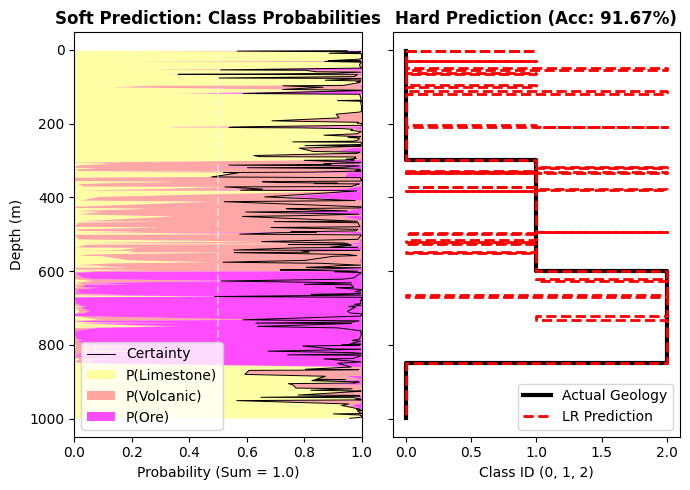


--- Model Coefficients (Weights) ---
            Density     Gamma  Resistivity  Mag_Suscept
Limestone -1.926893  1.092645     1.325146    -1.327664
Volcanic   0.279205 -1.449358     1.300949    -0.458548
Ore        1.647688  0.356714    -2.626095     1.786212


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ==========================================
# 1. DATA PREPARATION (The Physics Setup)
# ==========================================
np.random.seed(42)
n_samples = 1000
depth = np.linspace(0, 1000, n_samples)

# Define 3 Rock Units (0: Limestone, 1: Volcanic, 2: Ore)
y = np.zeros(n_samples)
y[300:600] = 1   # Middle section is Volcanic
y[600:850] = 2   # Bottom-middle is Ore

# Create 4 Physical Magnitudes with realistic noise/overlap
# We use 'y==X' to shift the mean based on the rock type
density = 2.4 + 0.25*(y==1) + 0.4*(y==2) + 0.15*np.random.randn(n_samples)
gamma   = 70 - 30*(y==1) - 10*(y==2) + 15*np.random.randn(n_samples)
res     = np.exp(4 - 1.2*(y==2) + 0.5*np.random.randn(n_samples))
mag_sus = 0.5 + 0.5*(y==1) + 2.0*(y==2) + 0.8*np.random.randn(n_samples)

# Combine into a feature matrix
features = ['Density', 'Gamma', 'Resistivity', 'Mag_Suscept']
X = np.column_stack([density, gamma, res, mag_sus])

# ==========================================
# 2. DATA SCIENCE PIPELINE
# ==========================================

# Step A: Scaling (Mandatory for Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step B: Train/Test Split
X_train, X_test, y_train, y_test, d_train, d_test = train_test_split(
    X_scaled, y, depth, test_size=0.3, random_state=42
)

# Step C: Train Logistic Regression
# 'C=1.0' is the regularization strength. 
# 'multinomial' allows it to see all 3 classes at once.
model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0)
model_lr.fit(X_train, y_train)

# Step D: Predictions
y_pred = model_lr.predict(X_test)
probs = model_lr.predict_proba(X_test) # Probability for each class

# ==========================================
# 3. VISUALIZATION
# ==========================================

# Sort test data by depth for clean plotting
sort_idx = np.argsort(d_test)
d_sorted = d_test[sort_idx]
p_sorted = probs[sort_idx]
y_true_sorted = y_test[sort_idx]
y_pred_sorted = y_pred[sort_idx]

fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharey=True)

# Calculate the certainty (the highest probability among the 3 classes)
certainty = np.max(p_sorted, axis=1)
# Plotting on the Probability Stack (ax[0])
ax[0].plot(certainty, d_sorted, color='black', lw=0.7, ls='-', label='Certainty')
ax[0].axvline(0.5, color='white', ls='--', alpha=0.5) # The "Tipping Point"
ax[0].legend(loc='lower left')

# PLOT 1: THE PROBABILITY STACK
# This shows how "sure" the model is at every meter
ax[0].fill_betweenx(d_sorted, 0, p_sorted[:, 0], facecolor='#FFFF80', label='P(Limestone)', alpha=0.7)
# Start (x_1): 0
# End (x_2): The probability of being Limestone (e.g., 0.6)
# Result: A block of yellow that fills from the left edge to the 0.6 mark
ax[0].fill_betweenx(d_sorted, p_sorted[:, 0], p_sorted[:, 0] + p_sorted[:, 1], facecolor='#FF8080', label='P(Volcanic)', alpha=0.7)
# Start (x_1): Where the Limestone ended (0.6)
# End (x_2): Limestone + Volcanic probabilities (e.g., 0.6 + 0.3 = 0.9).
# Result: A pink block that is 0.3 units wide, starting right after the yellow.
ax[0].fill_betweenx(d_sorted, p_sorted[:, 0] + p_sorted[:, 1], 1, facecolor='#FF00FF', label='P(Ore)', alpha=0.7)

ax[0].set_title("Soft Prediction: Class Probabilities", fontweight='bold')
ax[0].set_xlabel("Probability (Sum = 1.0)")
ax[0].set_ylabel("Depth (m)")
ax[0].set_xlim(0, 1)
ax[0].legend(loc='lower left')
ax[0].invert_yaxis()

# PLOT 2: THE HARD CLASSIFICATION (Actual vs Predicted)
ax[1].step(y_true_sorted, d_sorted, where='post', color='black', lw=3, label='Actual Geology')
ax[1].step(y_pred_sorted, d_sorted, where='post', color='red', ls='--', lw=2, label='LR Prediction')

ax[1].set_title(f"Hard Prediction (Acc: {accuracy_score(y_test, y_pred):.2%})", fontweight='bold')
ax[1].set_xlabel("Class ID (0, 1, 2)")
ax[1].legend()

plt.tight_layout()
plt.show()

# Print the weights of each sensor
print("\n--- Model Coefficients (Weights) ---")
print(pd.DataFrame(model_lr.coef_, columns=features, index=['Limestone', 'Volcanic', 'Ore']))

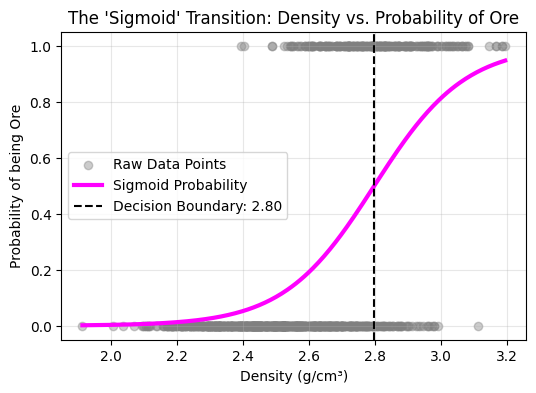

In [13]:
from sklearn.linear_model import LogisticRegression

# 1. We need a 1D model to see a clean Sigmoid
# Let's look at just Density vs "Is it Ore or Not?"
y_ore = (y == 2).astype(int) # 1 if Ore, 0 otherwise
X_density = X[:, 0].reshape(-1, 1) # Only Density

model_1d = LogisticRegression()
model_1d.fit(X_density, y_ore)

# 2. Create a smooth range of Density values for the curve
density_range = np.linspace(X_density.min(), X_density.max(), 300).reshape(-1, 1)
prob_ore = model_1d.predict_proba(density_range)[:, 1]

# 3. Plotting
plt.figure(figsize=(6, 4))
plt.scatter(X_density, y_ore, alpha=0.4, color='gray', label='Raw Data Points')
plt.plot(density_range, prob_ore, color='magenta', lw=3, label='Sigmoid Probability')

# Mark the "Decision Boundary" (where P = 0.5)
db_value = -model_1d.intercept_[0] / model_1d.coef_[0][0]
plt.axvline(db_value, color='black', ls='--', label=f'Decision Boundary: {db_value:.2f}')

plt.title("The 'Sigmoid' Transition: Density vs. Probability of Ore")
plt.xlabel("Density (g/cm³)")
plt.ylabel("Probability of being Ore")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

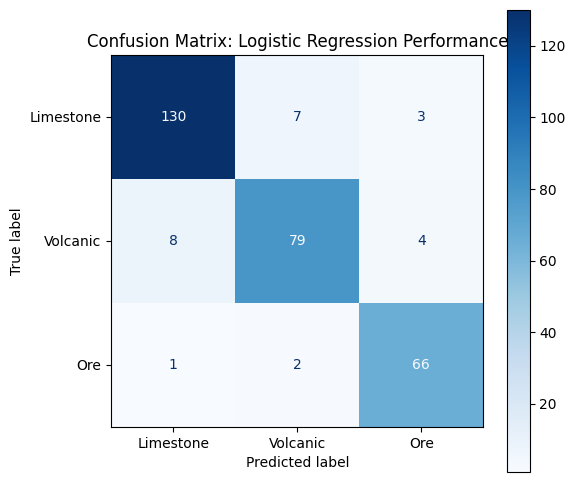

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Compute the confusion matrix
# y_test = actual labels, y_pred = model's guesses
cm = confusion_matrix(y_test, y_pred)

# 2. Plotting
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Limestone', 'Volcanic', 'Ore'])

disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Confusion Matrix: Logistic Regression Performance")
plt.show()

Technical Detail:  p_sorted[:, 0] \
The : means "all depths," and the 0 means "the first column of the probability matrix" (which corresponds to Class 0/Limestone).\
This is a standard NumPy slicing technique you'll use constantly in Data Science.

## Steps

1. The 1-Variable Case (The Simple Transition)Imagine you are only using Density ($x$) to predict if a rock is Ore ($y=1$) or Waste ($y=0$).The Linear Score ($z$)First, we calculate a weighted score, just like in a linear relationship:$$z = \beta_0 + \beta_1x$$$\beta_0$ (Intercept): The "baseline" likelihood of ore.$\beta_1$ (Weight/Coefficient): How much the probability shifts for every unit of Density.The Sigmoid "Squashing" FunctionThe problem is that $z$ can be any number from $-\infty$ to $+\infty$. To turn this into a probability ($P$), we pass it through the Sigmoid function:$$P(y=1) = \sigma(z) = \frac{1}{1 + e^{-z}}$$
If $z$ is very large and positive, $e^{-z}$ approaches 0, so $P \approx 1$.If $z$ is very large and negative, $e^{-z}$ approaches $\infty$, so $P \approx 0$.If $z = 0$, $P = 0.5$ (The Decision Boundary).

2. The 4-Variable Case (Multivariate Space)In your borehole project, you have Density, Gamma, Resistivity, and Mag_Suscept. The math doesn't change fundamentally; it just expands the "score" calculation into 4D space.The Multivariate Score ($z$)Now, $z$ is the dot product of your feature vector and your weight vector:$$z = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4$$
Where:\
$x_1, x_2, x_3, x_4$ are your 4 sensors. \
$\beta_1, \beta_2, \beta_3, \beta_4$ are the Coefficients you saw in the code output.\
The Multi-Dimensional Boundary \
In 1D, the "Decision Boundary" was a single point on a line. In 4D, the boundary is a hyperplane. The model is finding the orientation of this plane that best separates the Ore points from the Waste points.

3. Multi-Class Logic (The Softmax)  
To ensure they all sum to 1.0, it uses the Softmax Function:$$P(\text{class}_i) = \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}$$This is what allowed us to create that Probability Stack Plot. At any depth, the model calculates the "energy" ($z$) for each rock type and uses the Softmax to see which one "wins" the percentage of the stack.

4. How the computer finds the $\beta$ values? (Maximum Likelihood)\
Logistic Regression uses Maximum Likelihood Estimation (MLE).It tries different values for $\beta$ until it finds the ones that maximize the probability of the observed data. It's an optimization problem:Assume a set of $\beta$ weights.Calculate the probability of the actual borehole logs using those weights.Adjust the weights (using Gradient Descent) to make the "True" labels as close to $P=1$ as possible.

3 Explained  
The 4 Magnitudes are "Compressed" FirstEven though you have 4 sensors, the math first collapses them into a single value ($z$) for each rock type.$$z = \beta_0 + \beta_1(\text{Density}) + \beta_2(\text{Gamma}) + \beta_3(\text{Resistivity}) + \beta_4(\text{Mag\_Suscept})$$This $z$ is the "raw score." If $z$ is high, the model thinks that specific rock is very likely.\
If you had 2 rocks (Binary): You would use 1 Sigmoid. It would take that single $z$ and tell you the probability of Ore ($P$) vs. Waste ($1-P$).  
The Softmax function for Class $A$ looks like this:$$P(A) = \frac{e^{z_A}}{e^{z_A} + e^{z_B} + e^{z_C}}$$If you look closely at the math, if you remove Class $C$, the formula mathematically simplifies back into the standard Sigmoid function.